## Uber and Lyft prices analysis and price prediction

Data science project to conduct some Data Analysis, and build my first Machine Learning model - Linear Regression,
and my first Deep Learning model - Neural Network.


Preparing dataframe:

In [253]:
import numpy as np
import pandas as pd

In [254]:
weather_df = pd.read_csv('data/weather.csv')
rides_df = pd.read_csv('data/cab_rides.csv')

In [255]:
weather_df.describe()

,temp,clouds,pressure,rain,time_stamp,humidity,wind
count,6276.000000,6276.000000,6276.000000,894.000000,6.276000e+03,6276.000000,6276.000000
mean,39.090475,0.677777,1008.445209,0.057652,1.543857e+09,0.763985,6.802812
std,6.022055,0.314284,12.870775,0.100758,6.659340e+05,0.127340,3.633466
min,19.620000,0.000000,988.250000,0.000200,1.543204e+09,0.450000,0.290000
25%,36.077500,0.440000,997.747500,0.004900,1.543387e+09,0.670000,3.517500
50%,40.130000,0.780000,1007.660000,0.014850,1.543514e+09,0.760000,6.570000
75%,42.832500,0.970000,1018.480000,0.060925,1.544691e+09,0.890000,9.920000
max,55.410000,1.000000,1035.120000,0.780700,1.545159e+09,0.990000,18.180000


In [256]:
rides_df.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.189430,1.544046e+12,16.545125,1.013870
std,1.138937,6.891925e+08,9.324359,0.091641
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


In [257]:
rides_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [258]:
rides_df.isna().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [259]:
rides_df.dropna(inplace=True)
#rides_df.isna().sum()

In [260]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


I assume if there is NaN in rain that means there were no rain.

In [261]:
weather_df['rain'] = weather_df['rain'].fillna(0)

In [262]:
# Converting timestamp to date and removing timestamp column
weather_df['date'] = pd.to_datetime(weather_df['time_stamp'], unit='s')
rides_df['date'] = pd.to_datetime(rides_df['time_stamp'], unit='ms')
weather_df.drop('time_stamp', axis=1, inplace=True)
rides_df.drop('time_stamp', axis=1, inplace=True)

In [263]:
# dealing with error
pd.options.mode.chained_assignment = None 
df = pd.DataFrame()
for location in weather_df['location'].unique():
    # get entries with specific location
    rides_loc = rides_df[rides_df['source'] == location]
    weather_loc = weather_df[weather_df['location'] == location]
    
    rides_loc.sort_values(by='date', inplace=True)
    weather_loc.sort_values(by='date', inplace=True)
    
    # set weather for location from nearest date 
    new_df = weather_loc.set_index('date').reindex(rides_loc.set_index('date').index, method='nearest').reset_index()
    final_df = pd.merge(rides_loc, new_df, on='date')
    
    final_df.drop_duplicates(inplace=True)
    # adding to new, empty DF
    df = pd.concat([df, final_df])

In [264]:
df['surge_multiplier'].value_counts()

1.00    617001
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: surge_multiplier, dtype: int64

Now let's remove some usless columns for example:
 - id column
 - product_id (similar to name)
 - pressure, wind and  humidity (let's just limit ourselves to rain (+clouds) and temperature
 - surge_multiplier only a few entries are different from 1.0
 - date, all data comes from only 2 weeks so its really short period of time
 

In [265]:
df.drop(['id', 'product_id', 'pressure', 'wind', 'humidity', 'surge_multiplier', 'location'], axis=1, inplace=True)

In [266]:
df.head()

,distance,cab_type,destination,source,price,name,date,temp,clouds,rain
0,6.26,Uber,South Station,Back Bay,34.0,Black,2018-11-26 03:40:46.971,41.04,0.87,0.0
1,2.99,Lyft,North End,Back Bay,19.5,Lyft XL,2018-11-26 03:40:47.022,41.04,0.87,0.0
2,1.66,Lyft,Fenway,Back Bay,26.0,Lux,2018-11-26 03:40:47.023,41.04,0.87,0.0
3,2.31,Lyft,Haymarket Square,Back Bay,16.5,Lux,2018-11-26 03:40:47.738,41.04,0.87,0.0
4,2.31,Lyft,Haymarket Square,Back Bay,16.5,Lyft XL,2018-11-26 03:40:47.747,41.04,0.87,0.0


In [267]:
# Adding new columns, to compare prices with day of week and with hour
df['day_of_week'] = df['date'].dt.day_of_week


# Now we can remove date column because all data comes from short period of time 
# (~2 weeks) so it should not affect fares
df['hour'] = df['date'].dt.hour

In [268]:
df.head()

,distance,cab_type,destination,source,price,name,date,temp,clouds,rain,day_of_week,hour
0,6.26,Uber,South Station,Back Bay,34.0,Black,2018-11-26 03:40:46.971,41.04,0.87,0.0,0,3
1,2.99,Lyft,North End,Back Bay,19.5,Lyft XL,2018-11-26 03:40:47.022,41.04,0.87,0.0,0,3
2,1.66,Lyft,Fenway,Back Bay,26.0,Lux,2018-11-26 03:40:47.023,41.04,0.87,0.0,0,3
3,2.31,Lyft,Haymarket Square,Back Bay,16.5,Lux,2018-11-26 03:40:47.738,41.04,0.87,0.0,0,3
4,2.31,Lyft,Haymarket Square,Back Bay,16.5,Lyft XL,2018-11-26 03:40:47.747,41.04,0.87,0.0,0,3


In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637976 entries, 0 to 178931
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   distance     637976 non-null  float64       
 1   cab_type     637976 non-null  object        
 2   destination  637976 non-null  object        
 3   source       637976 non-null  object        
 4   price        637976 non-null  float64       
 5   name         637976 non-null  object        
 6   date         637976 non-null  datetime64[ns]
 7   temp         637976 non-null  float64       
 8   clouds       637976 non-null  float64       
 9   rain         637976 non-null  float64       
 10  day_of_week  637976 non-null  int64         
 11  hour         637976 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 63.3+ MB


# Visualization
Some plots to explore if we have a balanced dataset and wchich feature affects price the most

# Part 1: Comparing number of entries for categorial features

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

<AxesSubplot: title={'center': 'Numbers of entires for every day of week'}, xlabel='day_of_week', ylabel='count'>

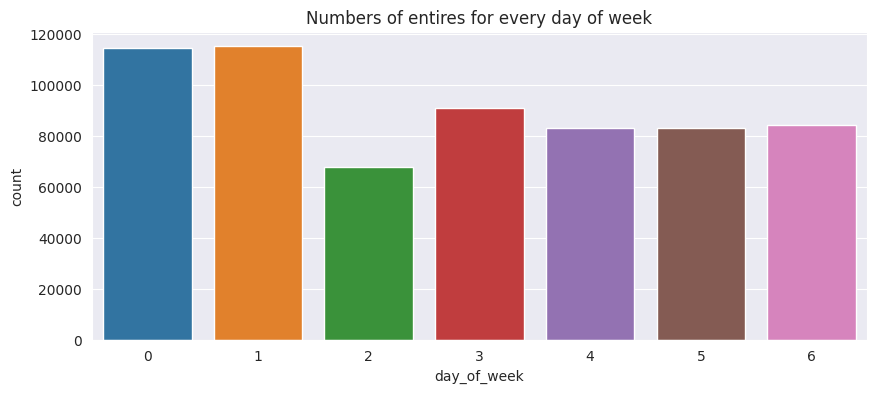

In [271]:
plt.figure(figsize=(10,4))
plt.title("Numbers of entires for every day of week")
sns.countplot(data=df, x='day_of_week')

Dataset contains less data from Wensday than from other days but it should be enough to do some data analysis and predictions

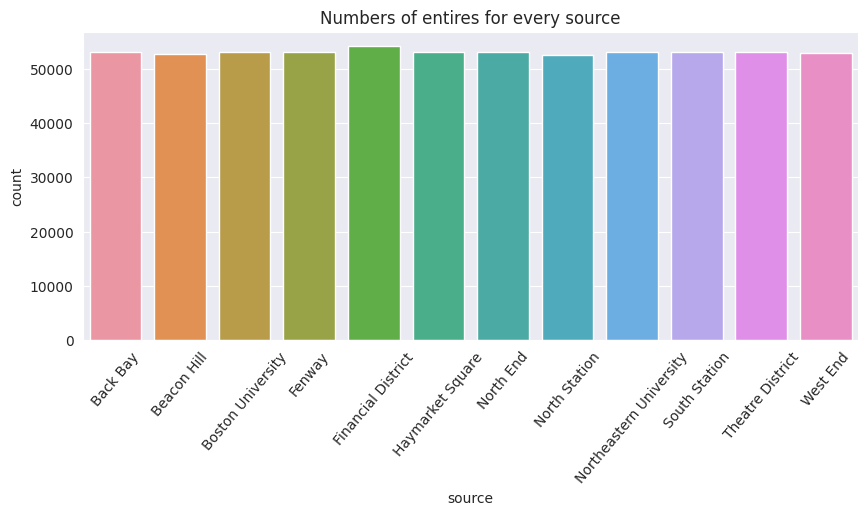

In [272]:
plt.figure(figsize=(10,4))
plt.title("Numbers of entires for every source")
g = sns.countplot(data=df, x='source')
g.tick_params(axis='x', rotation=50)

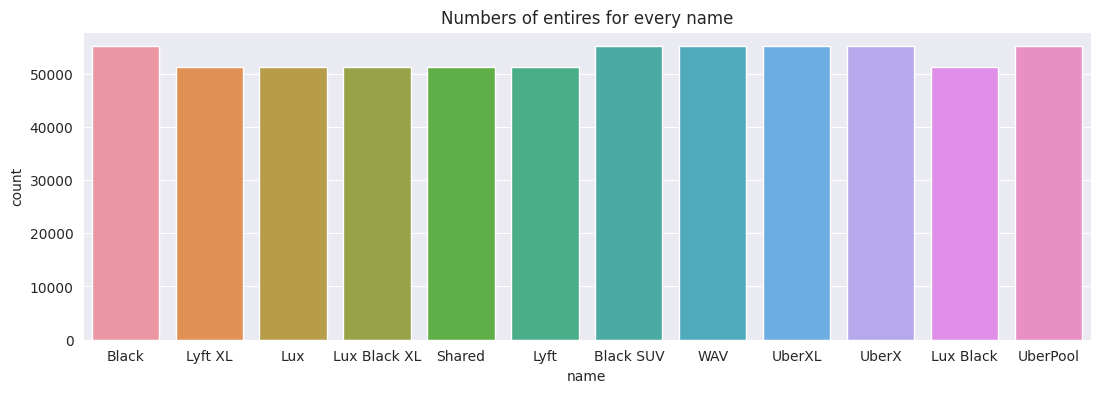

In [273]:
plt.figure(figsize=(13,4))
plt.title("Numbers of entires for every name")
g = sns.countplot(data=df, x='name')

# Part 2: Comparing price to some intuitive features

Text(0.5, 1.0, 'Price by distance')

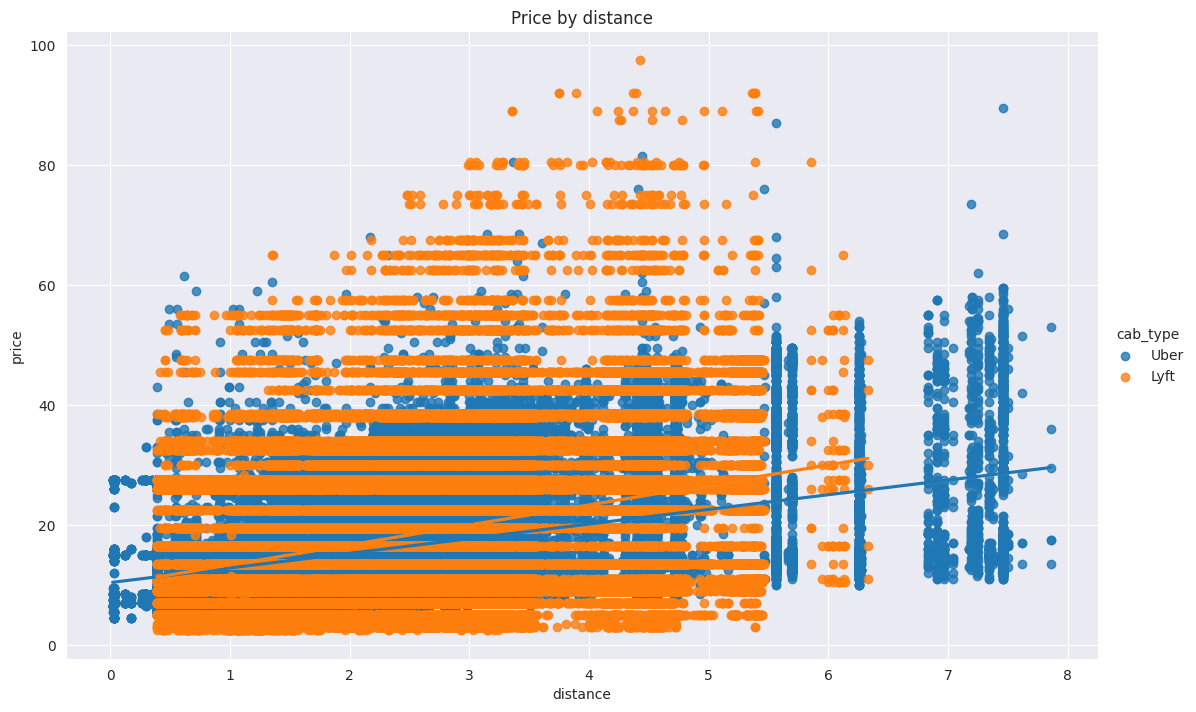

In [274]:
sns.lmplot(data=df, x='distance', y='price', hue='cab_type', height=7, aspect=1.6)
plt.title("Price by distance")

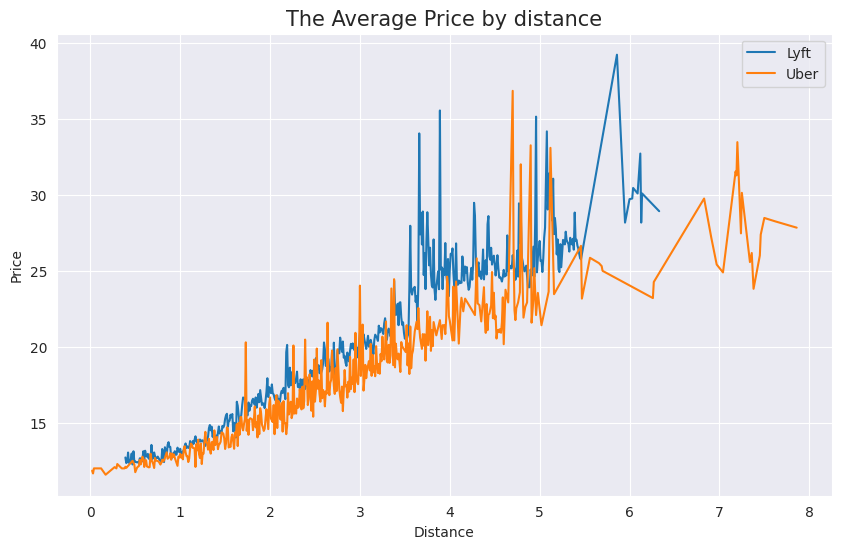

In [275]:
fig , ax = plt.subplots(figsize = (10,6))
ax.plot(df[df['cab_type'] == 'Lyft'].groupby('distance').price.mean().index, df[df['cab_type'] == 'Lyft'].groupby('distance')['price'].mean(), label = 'Lyft')
ax.plot(df[df['cab_type'] == 'Uber'].groupby('distance').price.mean().index, df[df['cab_type'] =='Uber'].groupby('distance').price.mean(), label = 'Uber')
ax.set_title('The Average Price by distance', fontsize= 15)
ax.set(xlabel = 'Distance', ylabel = 'Price' )
ax.legend()
plt.show()

It seems there is a little colleration between price and distance.
What is more Uber prices seems to be less scattered than Lyft prices

In [276]:
price_mean = df.groupby('cab_type')['price'].mean()
price_mean

cab_type
Lyft    17.351396
Uber    15.795343
Name: price, dtype: float64

In [277]:
print(f"Average Lyft is {(price_mean[0]  / price_mean[1]) * 100 - 100} % more expensive" )

Average Lyft is 9.851339990930711 % more expensive


We observe that uber average price tends to to be less than Lyft, this is very interesting conclusion

Text(0.5, 1.0, 'Price by clouds')

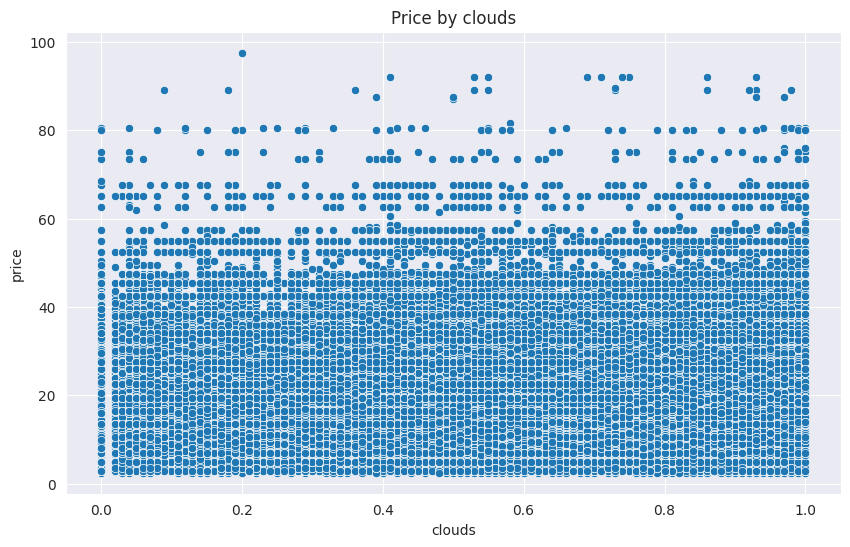

In [278]:
# Comparing price with rain, clouds and temperature
fig , ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=df, x='clouds', y='price')
ax.set_title("Price by clouds")

Here we can see that when clouds are near to 1.0 we have some more rides with higher price

Text(0.5, 1.0, 'Price by temperature')

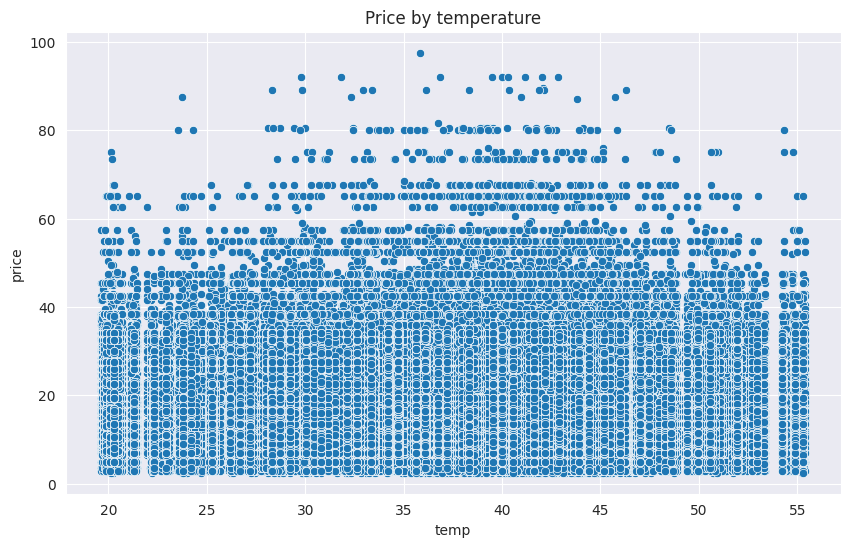

In [279]:
fig , ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=df, x='temp', y='price')
ax.set_title("Price by temperature")

Text(0.5, 1.0, 'Price by rain')

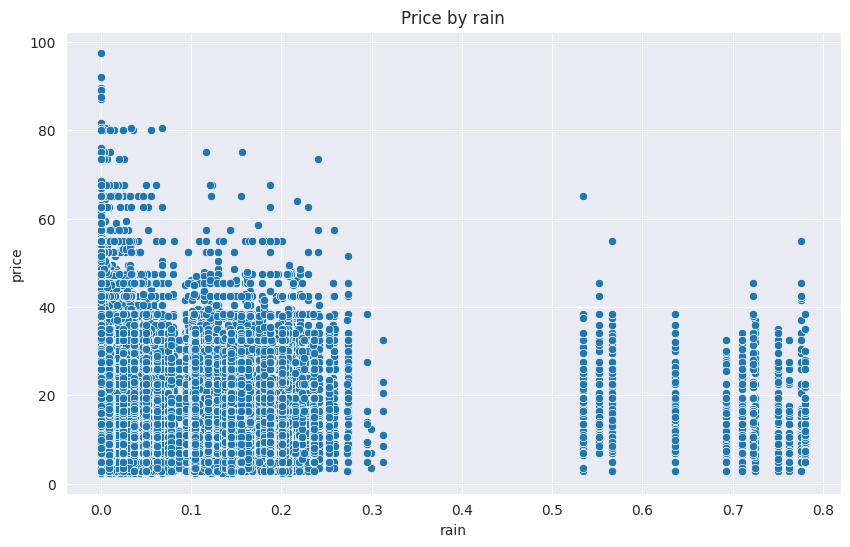

In [280]:
fig , ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=df, x='rain', y='price')
ax.set_title("Price by rain")

It is hard to say if there is any correlation between rain and price or temperature and price

Now i will try to compare some example routes to check if prices are different for specific week day or hours.

In [281]:
df["route"] = df["source"] + " -> " + df["destination"]

In [282]:
routes = df["route"].unique()

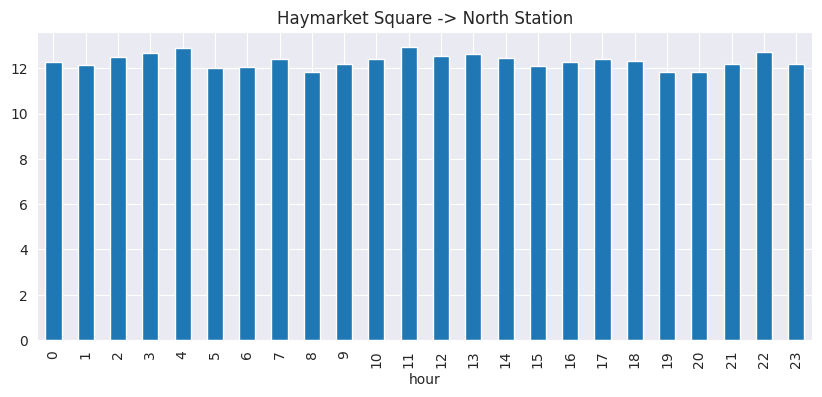

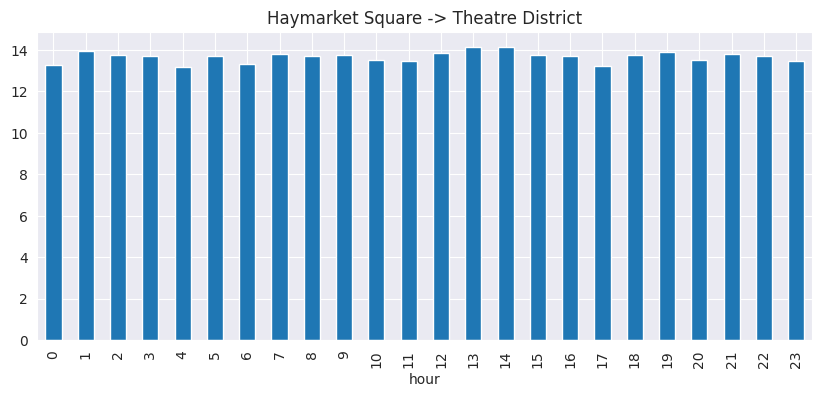

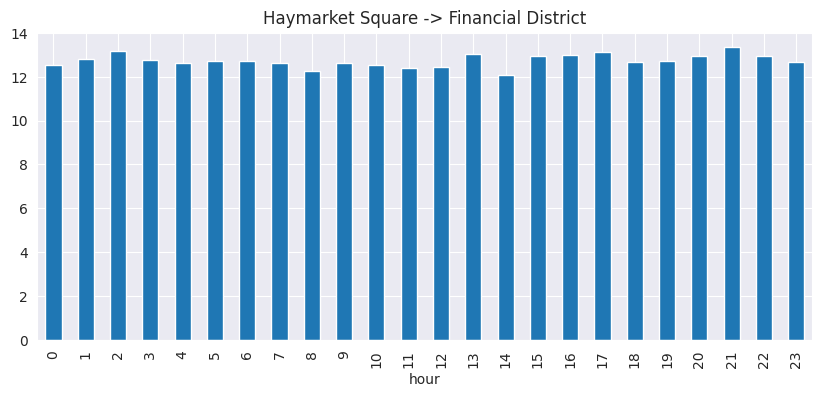

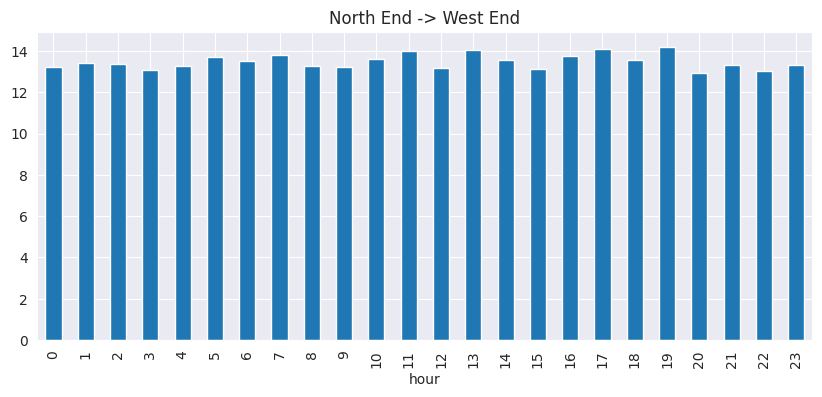

In [283]:
# Taking some random routes to compare price with hours and price with days of week
for elem in routes[33:37]:
    plt.figure(figsize=(10,4))
    df[df['route'] == elem].groupby('hour')['price'].mean().plot(kind="bar")
    plt.title(elem)

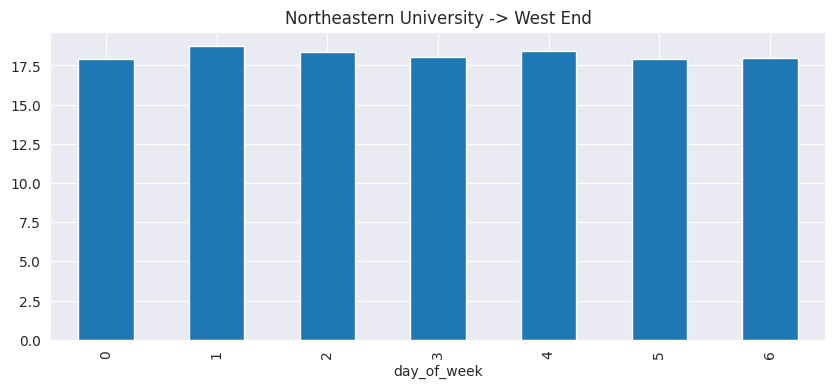

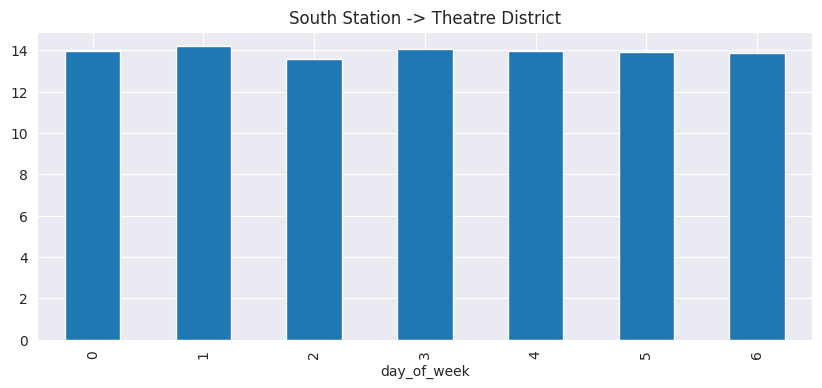

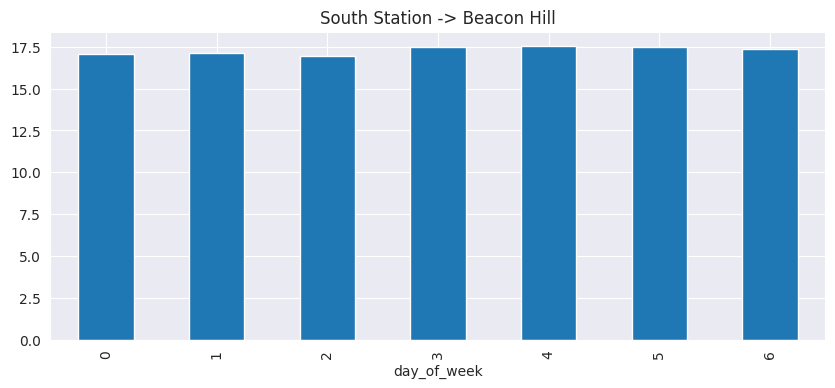

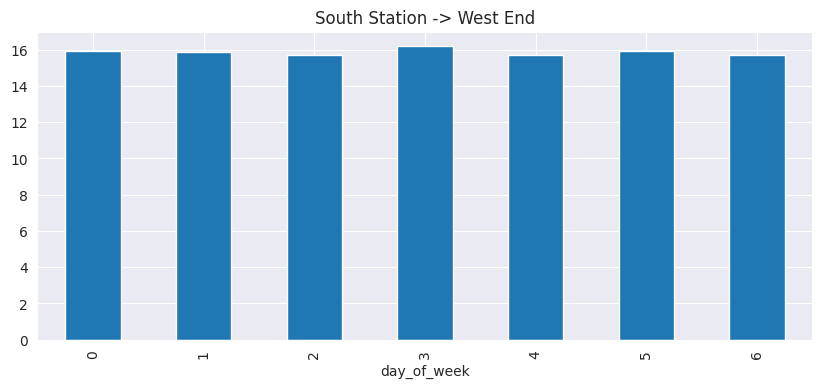

In [284]:
for elem in routes[53:57]:
    plt.figure(figsize=(10,4))
    df[df['route'] == elem].groupby('day_of_week')['price'].mean().plot(kind="bar")
    plt.title(elem)

From charts above we can read that there are some differences in prices between hours/days of week.
Differences hardly depends on the route we took. 

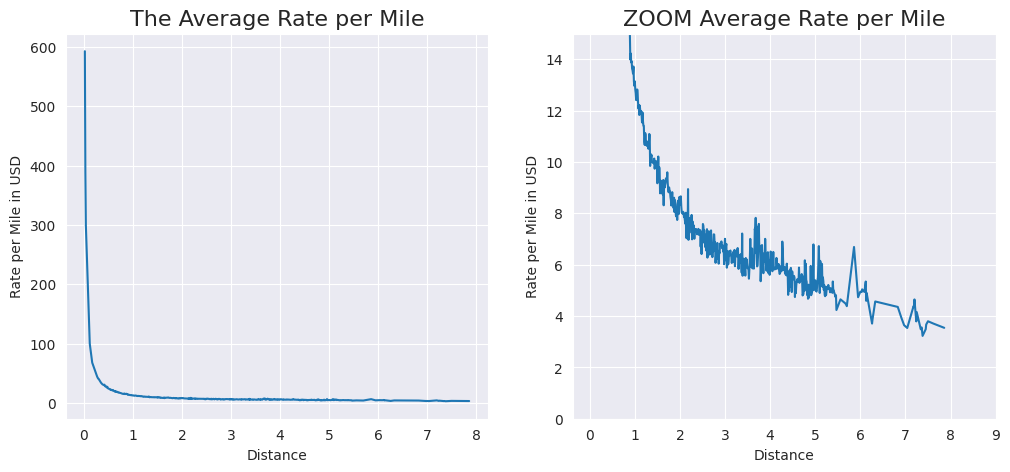

In [285]:
# Comparing Rate per Mile 
df['rate_per_mile'] = round((df['price'] / df['distance'] ),2)

fig, ax = plt.subplots(1,2,figsize = (12,5))
ax1 = sns.lineplot(x = df.groupby(['distance'])['rate_per_mile'].mean().index, y = df.groupby('distance')['rate_per_mile'].mean(), ax = ax[0])
ax2 = sns.lineplot(x = df.groupby(['distance'])['rate_per_mile'].mean().index, y = df.groupby('distance')['rate_per_mile'].mean(), ax = ax[1])

plt.xticks(range(0, 10,1))

ax1.set(xlabel = 'Distance', ylabel = 'Rate per Mile in USD')
ax2.set(xlabel = 'Distance', ylabel = 'Rate per Mile in USD', ylim = (0,15))
ax1.set_title('The Average Rate per Mile', fontsize = 16)
ax2.set_title('ZOOM Average Rate per Mile', fontsize = 16)

plt.show()

Here we have obvious result - the farther we ride the lower rate per mile we have.

Last thing i would like to compare is price by type of taxi (name)

[Text(0, 0, 'Black'),
 Text(1, 0, 'Lyft XL'),
 Text(2, 0, 'Lux'),
 Text(3, 0, 'Lux Black XL'),
 Text(4, 0, 'Shared'),
 Text(5, 0, 'Lyft'),
 Text(6, 0, 'Black SUV'),
 Text(7, 0, 'WAV'),
 Text(8, 0, 'UberXL'),
 Text(9, 0, 'UberX'),
 Text(10, 0, 'Lux Black'),
 Text(11, 0, 'UberPool')]

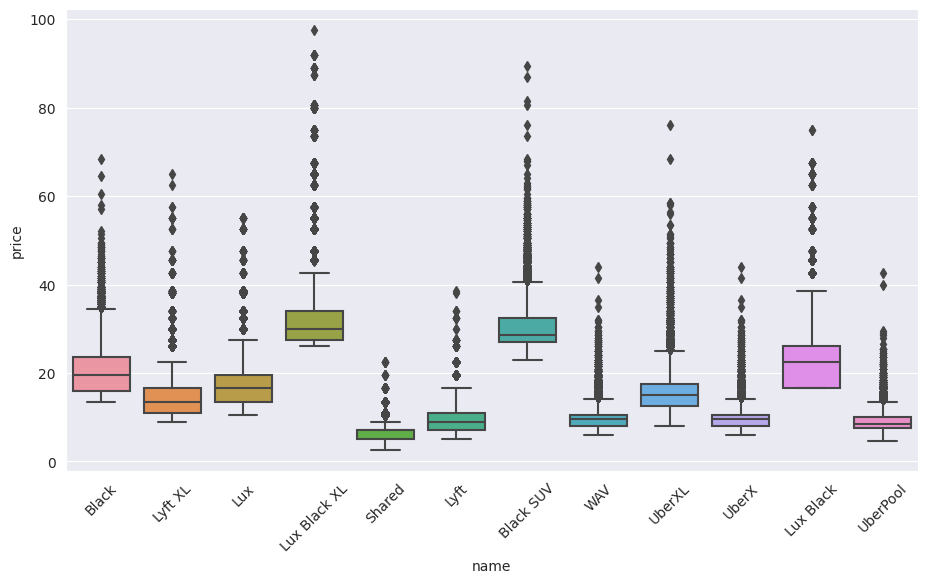

In [286]:
plt.figure(figsize=(11,6))
ax = sns.boxplot(x='name', y='price', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

We can see that we have 2 types of Taxi which are much more expensive than others - Lux Black XL and Black SUV

Text(0.5, 1.0, 'Distribution of price')

<Figure size 640x480 with 0 Axes>

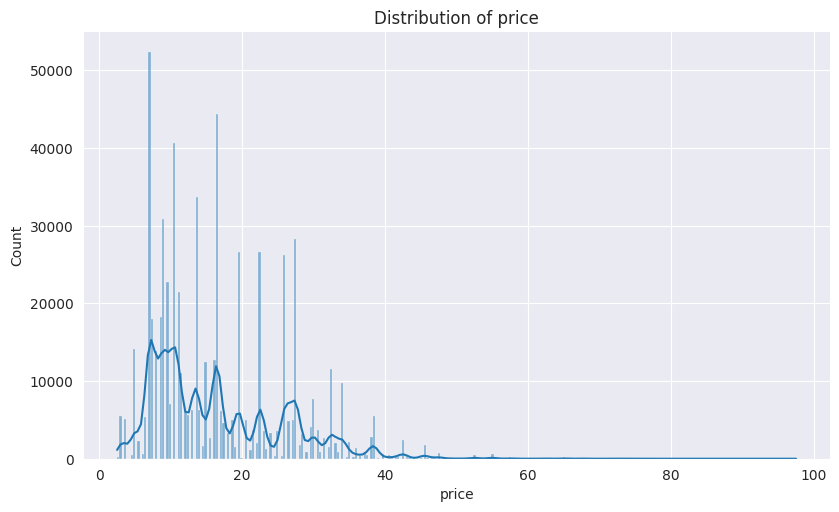

In [287]:
plt.figure()
ax = sns.displot(data=df, x="price", kde=True, height=5, aspect=1.7)
plt.title("Distribution of price")

## Distribution of distance

Text(0.5, 1.0, 'Distribution of distance')

<Figure size 640x480 with 0 Axes>

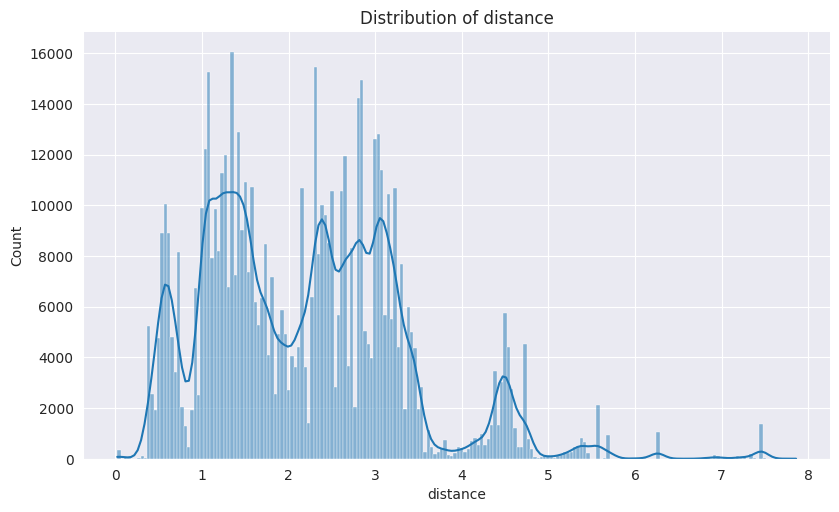

In [288]:
plt.figure()
ax = sns.displot(data=df, x="distance", kde=True, height=5, aspect=1.7)
plt.title("Distribution of distance")

/tmp/ipykernel_8994/1220756355.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="YlGnBu")


Text(0.5, 1.0, 'Heatmap of correlation matrix')

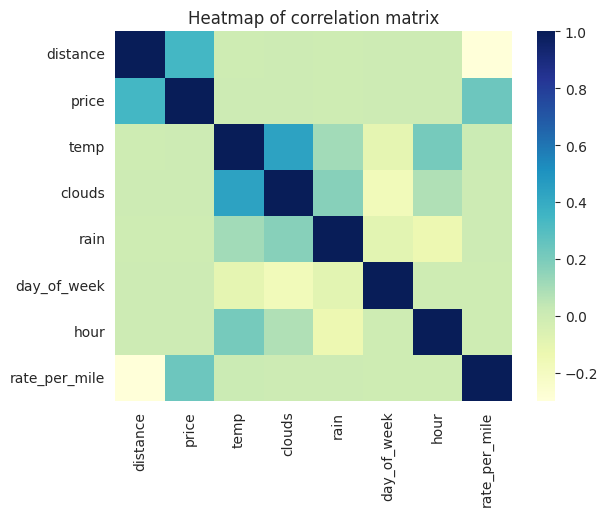

In [289]:
plt.figure()
sns.heatmap(df.corr(), cmap="YlGnBu")
plt.title("Heatmap of correlation matrix")

Here similar as before we can see that price is mainly correlated with distance, and only a little with other features.

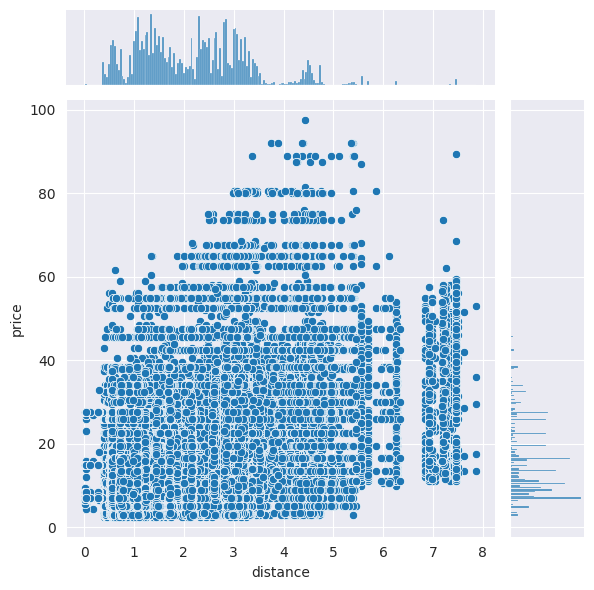

In [290]:
sns.jointplot(x='distance', y='price', data=df)

## Prediction - Linear Regression and Neural Network

## Part 3: Machine learning - Linear Regression

In [291]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [292]:
# First lets drop another usless column which is date - all data comes from 2 weeks so it should not affect much data
# Second drop route column because it was only used to simplify route analysis
# Column rate_per_mile has no meaning to price prediciton (it can be easily calculed from other 2 columns)

X = df.drop(['price', 'route', 'date', 'rate_per_mile'], axis=1)
y = df.drop(['route', 'date', 'rate_per_mile'], axis=1)['price']

In [293]:
# Dummies for categorical values
X = pd.get_dummies(X, columns=['cab_type', 'destination', 'source', 'name'], drop_first=True)

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [295]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [296]:
# checking Linear Regression coefficients
lm.coef_

array([ 2.89003469e+00,  8.25893015e-04, -1.78282458e-02, -4.49995963e-02,
       -3.17366235e-03, -4.08591994e-05,  3.36856184e+08, -3.15692845e-01,
       -5.70639483e+09, -5.70639483e+09,  3.85045529e-01, -5.70639483e+09,
       -5.70639483e+09,  2.04830261e-01, -5.70639483e+09, -5.70639483e+09,
        2.32339467e-01, -6.05838145e-02, -5.38745436e-01, -5.70639483e+09,
       -5.70639483e+09,  2.90658904e-02, -5.70639483e+09, -5.70639483e+09,
       -3.56631766e-01, -5.70639483e+09, -5.70639483e+09,  4.28057845e-01,
       -3.55393705e-01,  9.76410065e+00,  3.36856181e+08,  3.36856186e+08,
        3.36856195e+08,  3.36856173e+08,  3.36856178e+08,  3.36856169e+08,
       -1.17683957e+01, -1.07515138e+01, -4.83785316e+00, -1.07548966e+01])

In [297]:
predictions = lm.predict(X_test)

Text(0.5, 1.0, 'Real values by predicted values')

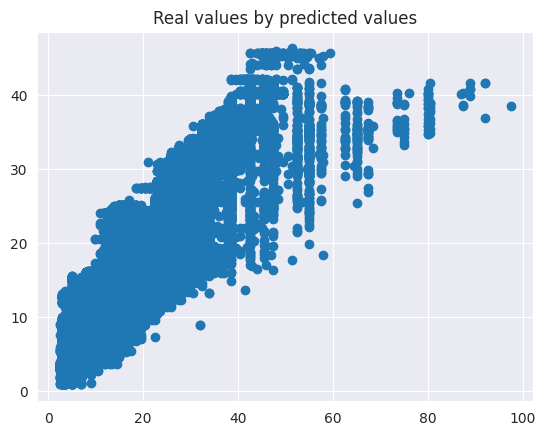

In [298]:
plt.scatter(x=y_test, y=predictions)
plt.title("Real values by predicted values")

# Model evaluation

In [299]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [300]:
print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

MAE: 1.9287009682492173
MSE: 9.309522591434133
RMSE: 3.0511510273066023


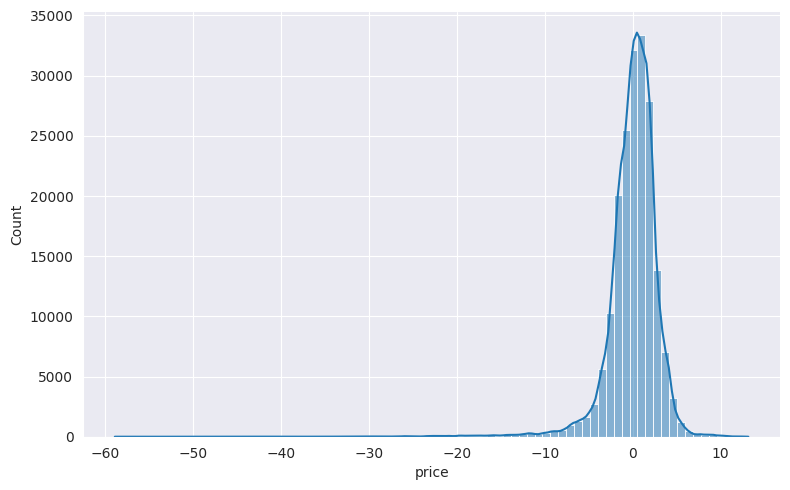

In [301]:
sns.displot((predictions - y_test), bins=80, kde=True, height=5, aspect=1.6)

# Part 4: Deep learning - Neural Network

Now as a experiment, try to predict price using simple neural network. It is much more complex model to implement, make predictions and to explain to potential client. In this case it is not recommended to do this this way but let's try.

In [302]:
# Scaling data to put it to the neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [303]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [304]:
X_test.shape

(191393, 40)

In [305]:
# Building model 40 -> 20 -> 10 -> 5 -> 1
model = Sequential()


# input layer
model.add(Dense(40,  activation='relu'))
model.add(Dropout(0.7))

# hidden layer
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.6))

# # hidden layer
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))

# # hidden layer
# model.add(Dense(5, activation='relu'))
# model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation='relu'))

# Compile model
model.compile(loss='mse', optimizer='adam')
# The less layer I add, the better result i get.

In [306]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

Epoch 1/25
1745/1745 [==============================] - 3s 2ms/step - loss: 83.7693 - val_loss: 15.7423
Epoch 2/25
1745/1745 [==============================] - 3s 2ms/step - loss: 50.0881 - val_loss: 14.3838
Epoch 3/25
1745/1745 [==============================] - 3s 2ms/step - loss: 44.7177 - val_loss: 13.9327
Epoch 4/25
1745/1745 [==============================] - 3s 2ms/step - loss: 38.8121 - val_loss: 12.0596
Epoch 5/25
1745/1745 [==============================] - 3s 2ms/step - loss: 35.1262 - val_loss: 12.7605
Epoch 6/25
1745/1745 [==============================] - 3s 2ms/step - loss: 31.8043 - val_loss: 10.9893
Epoch 7/25
1745/1745 [==============================] - 3s 2ms/step - loss: 28.5327 - val_loss: 11.8698
Epoch 8/25
1745/1745 [==============================] - 3s 2ms/step - loss: 26.5291 - val_loss: 12.8366
Epoch 9/25
1745/1745 [==============================] - 3s 2ms/step - loss: 25.2630 - val_loss: 12.7276
Epoch 10/25
1745/1745 [==============================] - 3s 2ms/

# Model evaluation

In [307]:
loses = pd.DataFrame(model.history.history)

<AxesSubplot: >

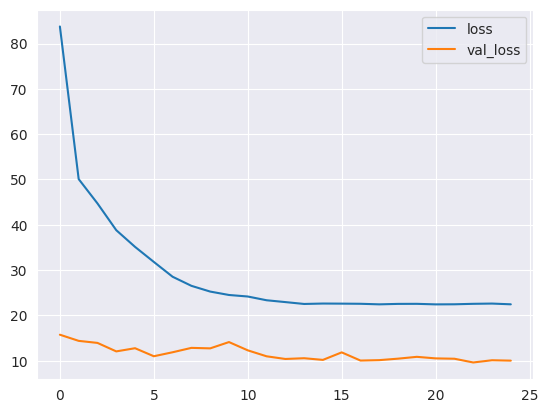

In [308]:
loses[['loss','val_loss']].plot()

In [309]:
predictions = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

5982/5982 [==============================] - 4s 588us/step
MAE: 2.055216812054403
MSE: 10.017656906823635
RMSE: 3.1650682309902316


Despite neural network is more complex model in this particular example it returns worse result, so I decided not to work with this model further. 

## Conclusion

* In general Lyft prices tends to be more scattered and higher than Uber's
* If there is more clouds it is more chances to pay higher price.
* In particular hours or day of week it is possible to pay ~ 10% less/more than in others
* The farther you ride the less rate per mile you pay
* The most expensive taxi names are "Lux Black XL" and "Lux Black"
* Price is mostly correlated with distance
* Most fares are in the range (5, 20) 
* Most distances are in range (1, 3.5) Miles

Prediction conclusion

* Simple Linear Regression model give us results with MAE: ~ 1.9 and RMSE: ~ 3
* Neural Network even if it is more complex model give us worst results with MAE: ~ 2 and RMSE: ~ 4.2